### Time series prediction using LSTM

Download dataset from Kaggle: Airline passenger

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('AirPassengers.csv')


In [4]:
df

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


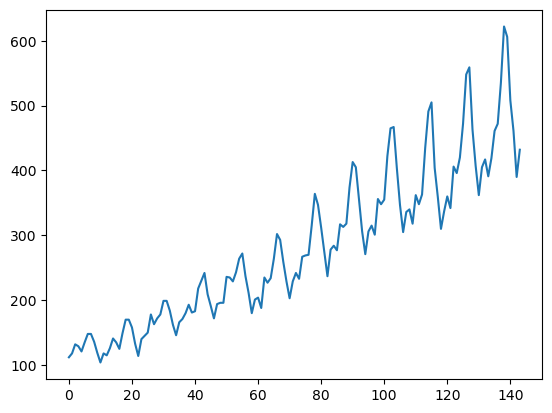

In [5]:
timeseries = df[["#Passengers"]].values.astype('float32')

plt.plot(timeseries)
plt.show()

In [6]:
# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [7]:
# It is designed to convert a time series into a tensor of dimensions (window sample, time steps, features).
import torch

def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

''' transform the time series data into input-output pairs suitable for training an LSTM.
For each time step in the time series, a window of a specified size (determined by lookback)
 is taken as input, and the next time step is taken as the output label.
 It is assumed to predict for one time step into the immediate future.
 This is done to create sequences for training the LSTM.
'''

' transform the time series data into input-output pairs suitable for training an LSTM.\nFor each time step in the time series, a window of a specified size (determined by lookback)\n is taken as input, and the next time step is taken as the output label.\n It is assumed to predict for one time step into the immediate future.\n This is done to create sequences for training the LSTM.\n'

Key in the definition is the shape of the input; that is what the model expects as input for each sample in terms of the number of time steps and the number of features.

In [8]:
lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([92, 4, 1]) torch.Size([92, 4, 1])
torch.Size([44, 4, 1]) torch.Size([44, 4, 1])


C:\Users\rahmat1\AppData\Local\Temp\ipykernel_14984\2185930874.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:278.)
  return torch.tensor(X), torch.tensor(y)


In [9]:
...
import torch.nn as nn

class AirModel(nn.Module):  #  In PyTorch, defining a neural network involves creating a class that inherits from nn.Module.
    def __init__(self):     # The class must have an __init__ method that initializes the layers of the neural network.
        super().__init__()  # The super() function is used to call the __init__ method of the parent class.
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True) #  creates an LSTM layer and assigns it to the self.lstm attribute of the model.
        self.linear = nn.Linear(50, 1)  # This linear layer will be used to map the output of the LSTM layer to a single predicted value.
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x
    

'''
 The forward method is where you define the computation performed by your model.
   This method defines how input data flows through the layers of the model to produce the output.
   batch_first = True:
   default - (sequence, batch, feature)
   here - (batch, sequence, feature)
   '''

'\n The forward method is where you define the computation performed by your model.\n   This method defines how input data flows through the layers of the model to produce the output.\n   batch_first = True:\n   default - (sequence, batch, feature)\n   here - (batch, sequence, feature)\n   '

DataLoader is a utility that helps in efficiently loading and iterating over datasets during training or evaluation. 

data.TensorDataset is a PyTorch dataset wrapper that takes tensors as input. It's used to wrap the input features (X_train) and the corresponding labels (y_train) into a single dataset object.

Using DataLoader in PyTorch provides several benefits:

-Efficient Data Loading: DataLoader loads data in parallel using multiple worker processes, which can speed up data loading, especially for large datasets.

-Batching: It automatically creates mini-batches of data, which is essential for stochastic gradient descent (SGD) optimization.

-Shuffling: It shuffles the data before creating mini-batches, helping to improve model generalization and prevent the model from memorizing the order of the data.

-Iterating over Data: It provides a convenient way to iterate over batches of data during training or evaluation, abstracting away the low-level details of data loading

In [10]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data

model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 225.6597, test RMSE 424.8913
Epoch 100: train RMSE 180.5734, test RMSE 377.6393
Epoch 200: train RMSE 145.8056, test RMSE 339.8206
Epoch 300: train RMSE 116.6861, test RMSE 305.8665
Epoch 400: train RMSE 93.9771, test RMSE 275.5707
Epoch 500: train RMSE 72.0651, test RMSE 243.2499
Epoch 600: train RMSE 56.5003, test RMSE 214.7489
Epoch 700: train RMSE 44.6906, test RMSE 189.2103
Epoch 800: train RMSE 36.7126, test RMSE 166.8299
Epoch 900: train RMSE 31.5110, test RMSE 148.2582
Epoch 1000: train RMSE 27.7252, test RMSE 132.2271
Epoch 1100: train RMSE 25.1991, test RMSE 118.7566
Epoch 1200: train RMSE 23.5156, test RMSE 108.2927
Epoch 1300: train RMSE 22.6128, test RMSE 100.5196
Epoch 1400: train RMSE 21.5348, test RMSE 94.3293
Epoch 1500: train RMSE 21.0539, test RMSE 89.6377
Epoch 1600: train RMSE 21.1192, test RMSE 85.5011
Epoch 1700: train RMSE 20.3936, test RMSE 82.3235
Epoch 1800: train RMSE 19.8365, test RMSE 80.1179
Epoch 1900: train RMSE 20.1630, test RMSE 78

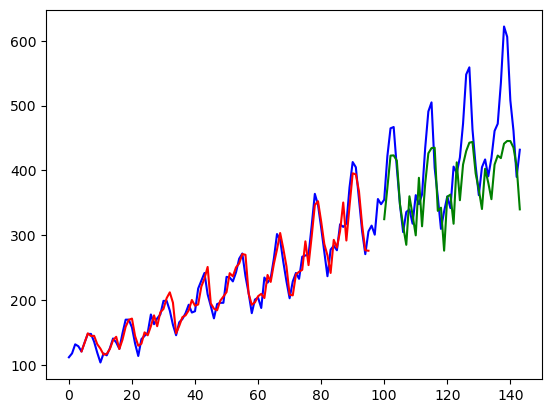

In [11]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()